$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 2: Ridge Regression with K-Fold Cross-Validation

*Zhixian (Jason) Yu*

## Overview

**Objective:**  To use ridge regression to model housing values in suburbs of Boston.

**Method:**  Ridge regression model with $\lambda$ ranging from 0 to 20 with a step size of 0.1. 

**Data source:** http://archive.ics.uci.edu/ml/machine-learning-databases/housing/

## Method

Independent viable (sample) was referred as $\Xv$, and dependent viable (target) was referred as $\Tv$. $\Xv$ was first standardized using the following formula:
$$\boldsymbol{Z} = (\Xv-\bar{\Xv})/\sigmav$$
Standardized $X$ was appended with one column of ones to calculate bias. Linear regression was solved using the following formula:
$$\boldsymbol{\omega} = (\boldsymbol{Z}^T \boldsymbol{Z} + \lambda\boldsymbol{I})^{-1} \boldsymbol{Z}^T \Tv$$

## Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def train(X, T, lamb):
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X, axis = 0)
    stand_X = (X- X_mean) / X_std
    X_input = np.hstack((np.ones((stand_X.shape[0], 1)), stand_X))
    lambdaDiag = np.eye(X_input.shape[1]) * lamb
    lambdaDiag[0,0] = 0.0
    w = np.linalg.lstsq (np.dot(X_input.T, X_input) + lambdaDiag, np.dot(X_input.T, T))[0]
    return {'means': X_mean, 'stds': X_std, 'w': w}

In [4]:
def use(model, X):
    X_mean = model['means']
    X_std = model['stds']
    stand_X = (X - X_mean) / X_std
    X_input = np.hstack((np.ones((stand_X.shape[0], 1)), stand_X))
    return np.dot(X_input, model['w'])

In [12]:
def rmse(predict, T):
    return np.sqrt(np.mean((predict - T)**2, axis = 0))

In [14]:
rmse(np.array([[1,2],[2,3]]), np.array([[1.1,1.9], [1.8,3.1]]))

array([ 0.1581,  0.1   ])

In [15]:
def rmse(predict, T):
    return np.sqrt(np.mean((predict - T)**2, axis))

In [16]:
rmse(np.array([[1,2],[2,3]]), np.array([[1.1,1.9], [1.8,3.1]]))

NameError: name 'axis' is not defined

In [6]:
def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=3):
    nSamples = X.shape[0]
    rowIndices = np.arange(nSamples)
    if shuffle:
        np.random.shuffle(rowIndices)
    nEach = nSamples // nFolds
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    starts = np.arange(0, nEach * nFolds, nEach)
    ends = starts + nEach
    ends[-1] = nSamples
    start_end = list(zip(starts, ends))
    for testfold in range(nFolds):
        for valfold in range(nFolds):
            if valfold == testfold:
                continue
            trainfold = np.setdiff1d(range(nFolds), [testfold, valfold])
            train_row = []
            for tf in trainfold:
                a, b = start_end[tf]
                train_row += rowIndices[a:b].tolist()
            X_train = X[train_row, :]
            T_train = T[train_row, :]
            
            a, b = start_end[testfold]
            test_row = rowIndices[a:b].tolist()
            X_test = X[test_row, :]
            T_test = T[test_row, :]
            
            a, b = start_end[valfold]
            val_row = rowIndices[a:b].tolist()
            X_val = X[val_row, :]
            T_val = T[val_row, :]
            
            yield X_train, T_train, X_val, T_val, X_test, T_test, testfold

In [7]:
def multipleLambdas(X,T,nFolds,lambdas = [0]):
    foldCount = 0
    results = []
    for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, _ in partitionKFolds(X, T, nFolds, True):
        for l in lambdas:
            model = train(Xtrain, Ttrain, l)
            predict_train = use(model, Xtrain)
            rmse_train = rmse(predict_train, Ttrain)
            predict_val = use(model, Xval)
            rmse_val = rmse(predict_val, Tval)
            predict_test = use(model, Xtest)
            rmse_test = rmse(predict_test, Ttest)
            results.append([foldCount, l, rmse_train, rmse_val, rmse_test])
        foldCount += 1
    results = np.array(results)
    bestResults = []
    #print results
    #print
    for cnt in range(foldCount):
        min_ind = np.argmin(results[ cnt * len(lambdas) : (cnt + 1) * len(lambdas), 3])
        bestResults.append(results[cnt * len(lambdas) + min_ind, :].tolist())
        #print(bestResults)
        #print
    return np.array(bestResults)

In [8]:
%precision 4

'%.4f'

## Data

**Source:**  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/

**Description:** This dataset contains 506 instances and 14 attributes. The first 13 attributes were used as sample features $X$, and the last one (*MEDV* : Median value of owner-occupied homes in \$1000's) was used as target $T$. The names and meanings of the 13 features are:
1. *CRIM *:      per capita crime rate by town
2. *ZN* :        proportion of residential land zoned for lots over 25,000 sq.ft.
3. *INDUS* :     proportion of non-retail business acres per town
4. *CHAS* :      Charles River dummy variable ( 1 if tract bounds river; 0 otherwise)
5. *NOX* :       nitric oxides concentration (parts per 10 million)
6. *RM* :        average number of rooms per dwelling
7. *AGE* :       proportion of owner-occupied units built prior to 1940
8. *DIS* :      weighted distances to five Boston employment centres
9. *RAD* :      index of accessibility to radial highways
10. *TAX* :     full-value property-tax rate per \$10,000
11. *PTRATIO* :  pupil-teacher ratio by town
12. *B* :        $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
13. *LSTAT* :    % lower status of the population


**Data plot (Fig 1):** 
<img src="https://github.com/zyu47/CS480_homework/blob/master/A1/data/relations.png?raw=true">

**Description of Data:**
1. Overall, we can see some correlations between the feature and the outcome, although at different levels.
2. Several features have obvious positive correlation with MEDV, including RM and ZN. For RM, it makes sense that houses with more rooms cost more. 
3. Several features have obvious negative correlation with MEDV, including CRIM, INDUS, NOX, and LSTAT. This indicates the neighborhood environment, i.e. the safety, convenience, environment and average salary is important for determing house price.
4. The effect of Charles River on MEDV is difficult to determine from this plot since it is a dummy variable with only values of 0 and 1.
5. The accessibility to highway (RAD) doesn't seem to impact house price in lower range, although there seems to be a slight positive correlation. However, when it is very difficult to access highways from the residence (RAD increases to >20), the house price gets lower. This indicates that people tend to choose a place that is not far away from highways, neight too close. 

## Results

In [30]:
!wget -P ./data/ http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
!wget -P ./data/ http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names

--2017-02-09 16:55:38--  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [text/plain]
Saving to: ‘./data/housing.data.2’

100%[======================================>] 49,082      --.-K/s   in 0.09s   

2017-02-09 16:55:38 (536 KB/s) - ‘./data/housing.data.2’ saved [49082/49082]

--2017-02-09 16:55:38--  http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2080 (2.0K) [text/plain]
Saving to: ‘./data/housing.names.2’

100%[======================================>] 2,080       --.-K/s   in 0.002s  

20

In [31]:
!head -10 ./data/housing.data

 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00
 0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80 396.90   9.14  21.60
 0.02729   0.00   7.070  0  0.4690  7.1850  61.10  4.9671   2  242.0  17.80 392.83   4.03  34.70
 0.03237   0.00   2.180  0  0.4580  6.9980  45.80  6.0622   3  222.0  18.70 394.63   2.94  33.40
 0.06905   0.00   2.180  0  0.4580  7.1470  54.20  6.0622   3  222.0  18.70 396.90   5.33  36.20
 0.02985   0.00   2.180  0  0.4580  6.4300  58.70  6.0622   3  222.0  18.70 394.12   5.21  28.70
 0.08829  12.50   7.870  0  0.5240  6.0120  66.60  5.5605   5  311.0  15.20 395.60  12.43  22.90
 0.14455  12.50   7.870  0  0.5240  6.1720  96.10  5.9505   5  311.0  15.20 396.90  19.15  27.10
 0.21124  12.50   7.870  0  0.5240  5.6310 100.00  6.0821   5  311.0  15.20 386.63  29.93  16.50
 0.17004  12.50   7.870  0  0.5240  6.0040  85.90  6.5921   5  311.0  15.20 386.71  17.10  18.90


In [32]:
# No missing data, so read the data directly
data = np.loadtxt('./data/housing.data')
#print data.shape

names = ['CRIM','ZN','INDUS','CHAS','NOX','RM', 'AGE','DIS', \
        'RAD','TAX','PTRATIO','B','LSTAT','MEDV']

%precision 4
data[:10,:];

In [33]:
# Seperate data into sample and target
# X as sample (first 13 columns), T as target
X = data[:, :13]
T = data[:, -1:]
#print X.shape
#print T.shape

xnames = names[:-1]
tname = names[-1]

####test below########

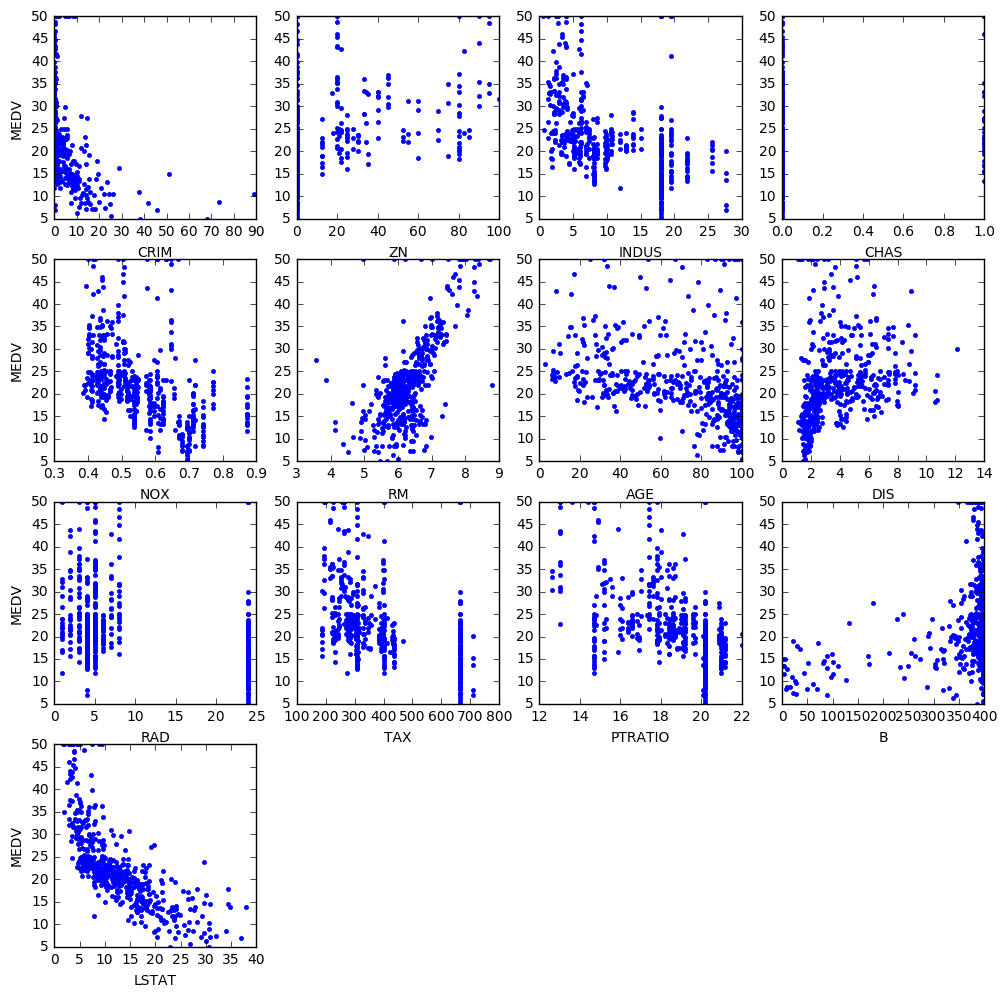

In [34]:
#plot diagrams describing the relationship between each feature and the output
#result plots are included in previous section called Data
plt.figure(figsize = (12,12))
for i in range(X.shape[1]):
    plt.subplot(4, 4, i+1)
    plt.plot(X[:,i], T[:,0],'.')
    plt.ylabel('' if i%4 else tname)
    plt.xlabel(xnames[i])
plt.savefig('./data/relations.png')

In [35]:
#train data with different lambdas, calculate mean validation error for each lambda
nFolds = 5
lambdas = np.arange(0, 20, 0.1)
rmse_table = [ [] for l in lambdas]
for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, _ in partitionKFolds(X, T, nFolds, True):
    for i in range(len(lambdas)):
        l = lambdas[i]
        model = train(Xtrain, Ttrain, l)
        predict_train = use(model, Xtrain)
        rmse_train = rmse(predict_train, Ttrain)
        predict_val = use(model, Xval)
        rmse_val = rmse(predict_val, Tval)
        predict_test = use(model, Xtest)
        rmse_test = rmse(predict_test, Ttest)
        rmse_table[i].append([l, rmse_train, rmse_val, rmse_test])
rmse_table = np.array(rmse_table)
rmse_mean = np.mean(rmse_table, axis = 1)
#print rmse_mean

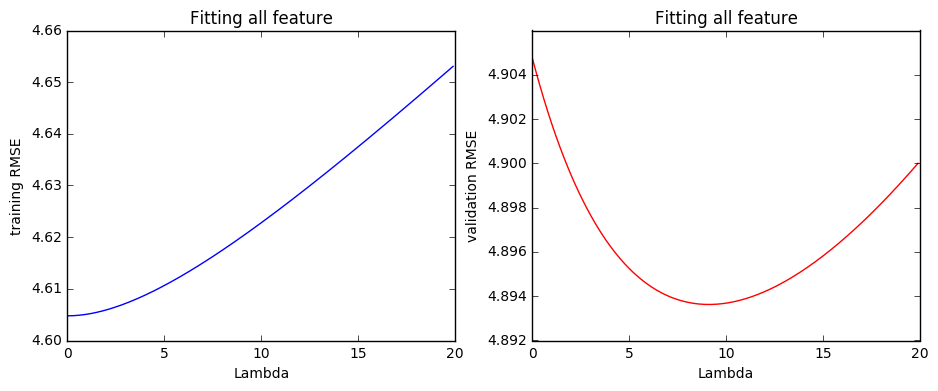

In [36]:
#plot rmse
plt.figure(figsize = (11,4));
plt.subplot(1,2,1);
plt.plot(rmse_mean[:, 0], rmse_mean[:, 1], 'b');
plt.ylabel('training RMSE');
plt.xlabel('Lambda');
plt.title ('Fitting all feature');
plt.subplot(1,2,2);
plt.plot(rmse_mean[:, 0], rmse_mean[:, 2], 'r');
plt.ylabel('validation RMSE');
plt.xlabel('Lambda');
plt.title ('Fitting all feature');


In [37]:
%precision 4
#best lambda
best_lambda_ind = np.argmin(rmse_mean[:, 2])
print zip(['lambda', 'training RMSE', 'validation RMSE', 'test RMSE'], rmse_mean[best_lambda_ind])

[('lambda', 9.0999999999999979), ('training RMSE', 4.6203528157379861), ('validation RMSE', 4.8936270010519474), ('test RMSE', 4.8936270010519465)]


**Analysis:** Acoording to the RMSE graph and best $\lambda$, $\lambda = 9.1$ gives the smallest validation error, indicating that ridge regression with $\lambda = 9.1$ is the optimal model under this circumstance. This gives a test error of 4.894, which is the same with training error because for both training and testing, excatly one fold of data was used. Therefore avearaging the RMSE produces the same answer for training and testing.

Next we train on all data with $\lambda = 9.1$

In [38]:
w = train(X, T, 8.2)['w'].flat
xnames.insert(0, 'bias')
sortOrder = np.argsort(np.abs(w))[::-1]
#print sortOrder
for (nw, nm) in zip(w[sortOrder], np.array(xnames)[sortOrder]):
    print ('{:8s} {:.3f}'.format(nm, nw))

bias     22.533
LSTAT    -3.644
DIS      -2.898
RM       2.733
RAD      2.180
PTRATIO  -2.000
NOX      -1.852
TAX      -1.637
ZN       0.974
CRIM     -0.870
B        0.846
CHAS     0.704
AGE      -0.025
INDUS    -0.016


**Analysis: ** Based on the weights, LSTAT is the most relevant feature and INDUS is the least relevant. Now we remove LSTAT or INDUS respectively to refit the model.

In [39]:
#remove most relevant data
rm_most_rel_index = sortOrder[2:] - 1
X_rm_most = X[:, rm_most_rel_index]

nFolds = 5
lambdas = np.arange(0, 20, 0.1)
rmse_table_rm_most = [ [] for l in lambdas]
for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, _ in partitionKFolds(X_rm_most, T, nFolds, True):
    for i in range(len(lambdas)):
        l = lambdas[i]
        model = train(Xtrain, Ttrain, l)
        predict_train = use(model, Xtrain)
        rmse_train = rmse(predict_train, Ttrain)
        predict_val = use(model, Xval)
        rmse_val = rmse(predict_val, Tval)
        predict_test = use(model, Xtest)
        rmse_test = rmse(predict_test, Ttest)
        rmse_table_rm_most[i].append([l, rmse_train, rmse_val, rmse_test])
rmse_table_rm_most = np.array(rmse_table_rm_most)
rmse_mean_rm_most = np.mean(rmse_table_rm_most, axis = 1)

#print rmse_mean_rm_most
best_lambda_rm_most_ind = np.argmin(rmse_mean_rm_most[:, 2])
print (rmse_mean_rm_most[best_lambda_rm_most_ind, :])

[ 5.9     5.1054  5.3453  5.3453]


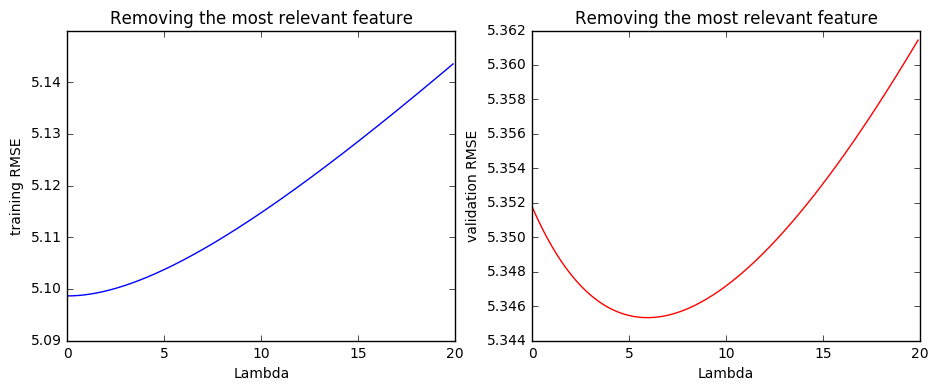

In [40]:
#plot rmse
plt.figure(figsize = (11,4));
plt.subplot(1,2,1);
plt.plot(rmse_mean_rm_most[:, 0], rmse_mean_rm_most[:, 1], 'b');
plt.ylabel('training RMSE');
plt.xlabel('Lambda');
plt.title ('Removing the most relevant feature');
plt.subplot(1,2,2);
plt.plot(rmse_mean_rm_most[:, 0], rmse_mean_rm_most[:, 2], 'r');
plt.ylabel('validation RMSE');
plt.xlabel('Lambda');
plt.title ('Removing the most relevant feature');


**Analysis: ** After removing the most relevant feature, the optimal $\lambda$ becomes 5.9, and the smallest validation RMSE is 5.345, which is larger than fitting all features.

In [41]:
#remove least relevant data
rm_least_rel_index = sortOrder[1:-1] - 1
X_rm_least = X[:, rm_least_rel_index]

nFolds = 5
lambdas = np.arange(0, 20, 0.1)
rmse_table_rm_least = [ [] for l in lambdas]
for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, _ in partitionKFolds(X_rm_least, T, nFolds, True):
    for i in range(len(lambdas)):
        l = lambdas[i]
        model = train(Xtrain, Ttrain, l)
        predict_train = use(model, Xtrain)
        rmse_train = rmse(predict_train, Ttrain)
        predict_val = use(model, Xval)
        rmse_val = rmse(predict_val, Tval)
        predict_test = use(model, Xtest)
        rmse_test = rmse(predict_test, Ttest)
        rmse_table_rm_least[i].append([l, rmse_train, rmse_val, rmse_test])
rmse_table_rm_least = np.array(rmse_table_rm_least)
rmse_mean_rm_least = np.mean(rmse_table_rm_least, axis = 1)
#print(rmse_mean_rm_least)

best_lambda_rm_least_ind = np.argmin(rmse_mean_rm_least[:, 2])
print (rmse_mean_rm_least[best_lambda_rm_least_ind, :])

[ 5.8     4.6462  4.8298  4.8298]


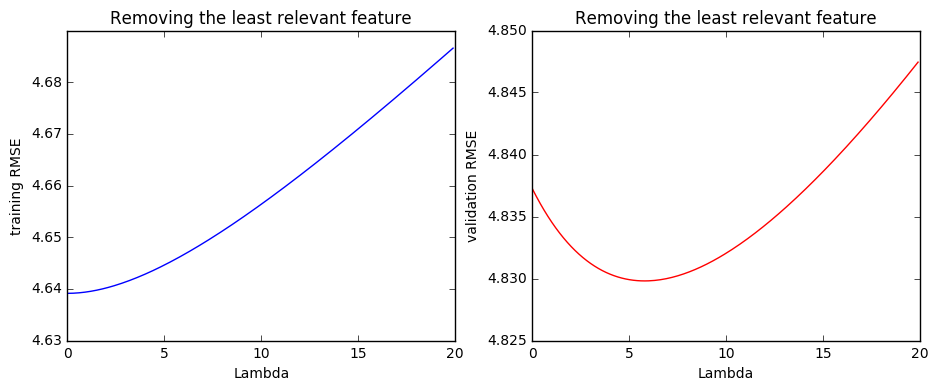

In [42]:
#plot rmse
plt.figure(figsize = (11,4));
plt.subplot(1,2,1);
plt.plot(rmse_mean_rm_least[:, 0], rmse_mean_rm_least[:, 1], 'b');
plt.ylabel('training RMSE');
plt.xlabel('Lambda');
plt.title ('Removing the least relevant feature');
plt.subplot(1,2,2);
plt.plot(rmse_mean_rm_least[:, 0], rmse_mean_rm_least[:, 2], 'r');
plt.ylabel('validation RMSE');
plt.xlabel('Lambda');
plt.title ('Removing the least relevant feature');


**Analysis:** After removing the most relevant feature, the optimal $\lambda$ becomes 5.8, and the smallest validation RMSE is 4.83, which is smaller than fitting all features and removing most relevant feature. This indicates that the INDUS feature may simply introduce noise into the model.

## Grading

Your notebook will be run and graded automatically.  After running all of the above cells in your notebook, run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 80/100 if your functions are defined correctly.  The remaining 20% will be based on the instructors reading of your notebooks.  We will be looking for how well the method is explained in text with some LaTeX math, and how well the results are summarized.

As before, first download and extract from [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs
480/notebooks/A2grader.tar) 

In [13]:
%run -i "A2grader.py"

 Testing:
X = np.arange(20).reshape((-1,1))
T = np.abs(X -10) + X
for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,5,shuffle=False,nPartitions=3)
20/20 points. partitionKFolds produced 20 partitions. Correct.
10/10 points. Final training set contains 12 samples. Correct.
10/10 points. Final validation set contains 4 samples. Correct.
Testing:
X = np.linspace(0,100,1000).reshape((-1,1))
T = X * 0.1
results = multipleLambdas(X,T,4,range(0,10))
20/20 points. All best lambdas are 0.  Correct.
20/20 points. Mean of all train, validation and test errors for best lambda are correct.

A2 Grade is 80/100
Up to 20 more points will be given based on the qualty of your descriptions of the method and the results.


## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A2.ipynb```.  So, for me it would be ```Anderson-A2.ipynb```.  Submit the file using the ```Assignment 2``` link on [Canvas](https://colostate.instructure.com/courses/41327).

Grading will be based on 

  * correct behavior of the three functions listed above,
  * easy to understand plots in your notebook
  * readability of the notebook,
  * effort in making interesting observations, and in formatting your notebook.